In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import least_squares
import seaborn as sns
import math
from scipy.stats import norm
import scipy.optimize as optimize
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.optimize import Bounds
import warnings
warnings.filterwarnings("ignore")


In [2]:
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma


In [3]:
zero_rates= pd.read_csv("zero_rates_20201201.csv")
#zero_rates

## Interpolate interest rates to options maturity days

Interpolated value at x=17: y=0.12550044444444444
Interpolated value at x=45: y=0.20510755555555554
Interpolated value at x=80: y=0.220628


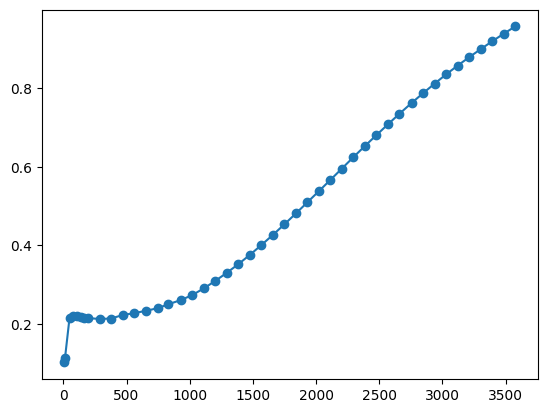

In [4]:
# Plot interest rate graph, interpolate i/r at different days left
plt.plot(zero_rates['days'], zero_rates['rate'], marker='o', linestyle='-')

# Values at which you want to interpolate
x_interpolate = [17, 45, 80]

# Interpolate the corresponding y-values
y_interpolate = np.interp(x_interpolate, zero_rates['days'], zero_rates['rate'])

# Print the interpolated values
for x_val, y_val in zip(x_interpolate, y_interpolate):
    print(f"Interpolated value at x={x_val}: y={y_val}")

# Show the plot
plt.show()

## DDM Calibration, SPX, 17 days

In [23]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        elif K < F:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPX_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[0]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.13 / 100.0  # Modify as needed
F = 3662.45*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

####################
# import matplotlib.pyplot as plt

# # Filter out-of-the-money options
# out_of_the_money_calls = call_df[call_df['strike'] > F]
# out_of_the_money_puts = put_df[put_df['strike'] < F]

# # Calculate implied volatilities for out-of-the-money calls and puts
# implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
# implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# # Combine strike prices and implied volatilities for calls and puts
# strike_prices_call = out_of_the_money_calls['strike'].values
# strike_prices_put = out_of_the_money_puts['strike'].values

# # Plot the implied volatility smile curve for out-of-the-money call options
# plt.plot(strike_prices_call, implied_vols_call, label='Implied Volatility (OTM Call)', linewidth=2.0)

# # Plot the implied volatility smile curve for out-of-the-money put options
# plt.plot(strike_prices_put, implied_vols_put, label='Implied Volatility (OTM Put)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve for OTM Options')
# plt.legend()
# plt.grid(True)
# plt.show()
############

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put


## iterate beta
beta_iterate = [0.0, 0.4, 0.8]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call_0 = [impliedVolatility(F, K, r, price, T, beta_iterate[1]) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put_0 = [impliedVolatility(F, K, r, price, T, beta_iterate[1]) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices_0 = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM_0 = implied_vols_call_0 + implied_vols_put_0

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call_1 = [impliedVolatility(F, K, r, price, T, beta_iterate[2]) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put_1 = [impliedVolatility(F, K, r, price, T, beta_iterate[2]) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices_1 = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM_1 = list(implied_vols_call_1 + implied_vols_put_1)

# tuple_set = list(zip(strike_prices_1, implied_vols_DDM_1))
# x, y = zip(*tuple_set)
# strike_prices_1 = sorted(strike_prices_1)


# Plot the implied volatility smile curve for out-of-the-money options
# plt.scatter(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM), beta = 0.2', linewidth=2.0)
# plt.scatter(strike_prices_0, implied_vols_DDM_0, label='Implied Volatility (OTM), beta = 0.4', linewidth=2.0)
# plt.scatter(strike_prices_1, implied_vols_DDM_1, label='Implied Volatility (OTM, beta = 0.8', linewidth=2.0)
# #plt.plot(x, y, marker='o', linestyle='-')
# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.1, beta: 0.2


## SABR Calibration, SPX, 17 days

In [29]:
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
df_17 = pd.read_csv('SPX_options.csv')
df_17['mid'] = 0.5*(df_17['best_bid'] + df_17['best_offer'])
df_17['strike'] = df_17['strike_price']*0.001
df_17['payoff'] = df_17['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(df_17['exdate'].unique())[0]
df_17 = df_17[df_17['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 3662.45
r = 0.13/100.0 #modify?
F = S*np.exp(r*T)

df_17['vols'] = df_17.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
df_17.dropna(inplace=True)
call_df = df_17[df_17['payoff'] == 'call']
put_df = df_17[df_17['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
df_17 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_17['strike'],
                                              df_17['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


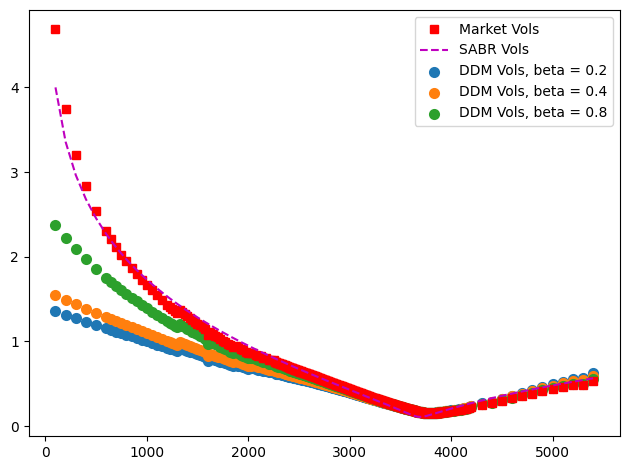

In [30]:
plt.figure(tight_layout=True)
plt.plot(strikes, df_17['impliedvol'], 'rs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')

# Plot the implied volatility smile curve for out-of-the-money call options
#plt.plot(strike_prices_call, implied_vols_call, label='Implied Volatility (OTM Call)', linewidth=2.0)

# Plot the implied volatility smile curve for out-of-the-money put options
#plt.plot(strike_prices_put, implied_vols_put, label='Implied Volatility (OTM Put)', linewidth=2.0)

plt.scatter(strike_prices, implied_vols_DDM, label='DDM Vols, beta = 0.2', linewidth=2.0)
plt.scatter(strike_prices_0, implied_vols_DDM_0, label='DDM Vols, beta = 0.4', linewidth=2.0)
plt.scatter(strike_prices_1, implied_vols_DDM_1, label='DDM Vols, beta = 0.8', linewidth=2.0)

#plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
#plt.plot(strike_prices_0, implied_vols_DDM_0,'y.', label='DDM Vols, beta=0.5')
#plt.plot(strike_prices_1, implied_vols_DDM_1,'b-', label='DDM Vols, beta=1.0')

plt.legend()
plt.show()

## DDM Calibration, SPX, 45 days

In [8]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        else:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPX_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[1]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.21 / 100.0  # Modify as needed
F = 3662.45*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put

# # Plot the implied volatility smile curve for out-of-the-money options
# plt.plot(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.1942605767078367, beta: 5.107486409536649e-05


## SABR Calibration, SPX, 45 days

In [9]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

df_45 = pd.read_csv('SPX_options.csv')
df_45['mid'] = 0.5*(df_45['best_bid'] + df_45['best_offer'])
df_45['strike'] = df_45['strike_price']*0.001
df_45['payoff'] = df_45['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(df_45['exdate'].unique())[1]
df_45 = df_45[df_45['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 3662.45
r = 0.21/100.0
F = S*np.exp(r*T)

df_45['vols'] = df_45.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
df_45.dropna(inplace=True)
call_df = df_45[df_45['payoff'] == 'call']
put_df = df_45[df_45['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
df_45 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_45['strike'],
                                              df_45['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

# plt.figure(tight_layout=True)
# plt.plot(strikes, df['impliedvol'], 'gs', label='Market Vols')
# plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
# plt.legend()
# plt.show()



Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


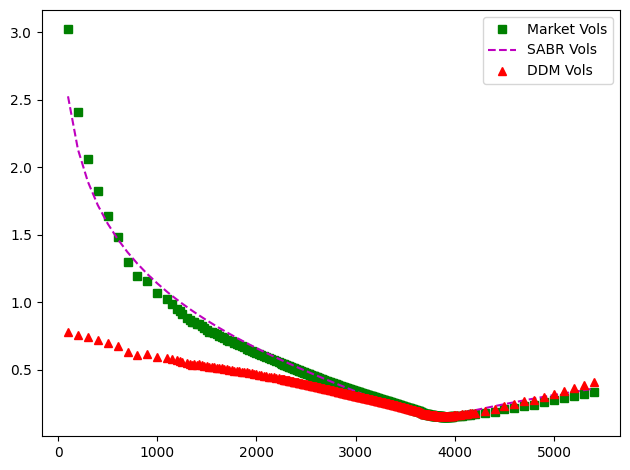

In [10]:
plt.figure(tight_layout=True)
plt.plot(strikes, df_45['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

## DDM Calibration, SPX, 80 days

In [11]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        else:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPX_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[2]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.22 / 100.0  # Modify as needed
F = 3662.45*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put

# # Plot the implied volatility smile curve for out-of-the-money options
# plt.plot(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.1, beta: 0.2


In [12]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

df_80 = pd.read_csv('SPX_options.csv')
df_80['mid'] = 0.5*(df_80['best_bid'] + df_80['best_offer'])
df_80['strike'] = df_80['strike_price']*0.001
df_80['payoff'] = df_80['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(df_80['exdate'].unique())[2]
df_80 = df_80[df_80['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 3662.45
r = 0.22/100.0
F = S*np.exp(r*T)

df_80['vols'] = df_80.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
df_80.dropna(inplace=True)
call_df = df_80[df_80['payoff'] == 'call']
put_df = df_80[df_80['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
df_80 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df_80['strike'],
                                              df_80['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

# plt.figure(tight_layout=True)
# plt.plot(strikes, df_80['impliedvol'], 'gs', label='Market Vols')
# plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
# plt.legend()
# plt.show()



Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


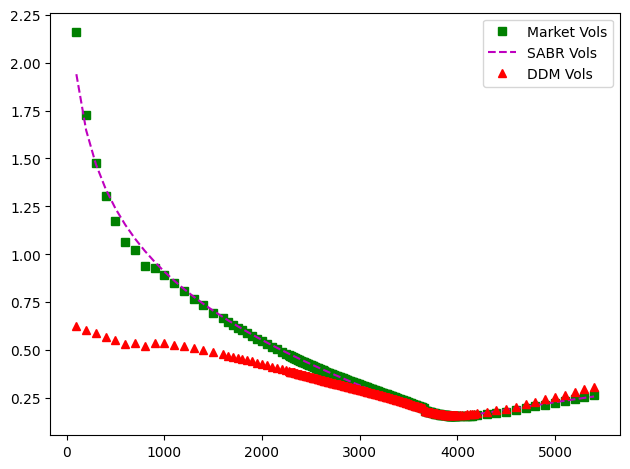

In [13]:
plt.figure(tight_layout=True)
plt.plot(strikes, df_80['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

## DDM Calibration, SPY, 17 days

In [14]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        else:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPY_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[0]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.13 / 100.0  # Modify as needed
F = 366.02*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put

# # Plot the implied volatility smile curve for out-of-the-money options
# plt.plot(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.20226869293118685, beta: 0.00020471219589401606


## SABR Calibration, SPY, 17 days

In [92]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

SPY_df_17 = pd.read_csv('SPY_options.csv')
SPY_df_17['mid'] = 0.5*(SPY_df_17['best_bid'] + SPY_df_17['best_offer'])
SPY_df_17['strike'] = SPY_df_17['strike_price']*0.001
SPY_df_17['payoff'] = SPY_df_17['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(SPY_df_17['exdate'].unique())[0]
SPY_df_17 = SPY_df_17[SPY_df_17['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 366.02
r = 0.13/100.0 #modify?
F = S*np.exp(r*T)

SPY_df_17['vols'] = SPY_df_17.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
SPY_df_17.dropna(inplace=True)
call_df = SPY_df_17[SPY_df_17['payoff'] == 'call']
put_df = SPY_df_17[SPY_df_17['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
SPY_df_17 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              SPY_df_17['strike'],
                                              SPY_df_17['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

#### Modify rho
rho_para = np.array([-1.0, -0.5, 0.0, 0.5, 1.0])

# List to store sabrvols_iter lists for each rho_para
all_sabrvols_rho = []

for rho in rho_para:
    #print("rho:", rho)
    sabrvols_iter = []
    
    for K in strikes:
        sabrvols_iter.append(SABR(F, K, T, alpha, beta, rho, nu))
    
    # Append the sabrvols_iter list for the current rho to all_sabrvols
    all_sabrvols_rho.append(sabrvols_iter)

#### Modify nu
nu_para = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

# List to store sabrvols_iter lists for each nu_para
all_sabrvols_nu = []

for nu in nu_para:
    #print("nu:", nu)
    sabrvols_iter_nu = []
    
    for K in strikes:
        sabrvols_iter_nu.append(SABR(F, K, T, 0.665, 0.7, -0.412, nu))
    
    # Append the sabrvols_iter_nu list for the current nu to all_sabrvols_nu
    all_sabrvols_nu.append(sabrvols_iter_nu)

# all_sabrvols_nu now contains the lists of sabrvols_iter for each nu_para
#print(all_sabrvols_nu)


# all_sabrvols now contains the lists of sabrvols_iter for each rho_para
#print(all_sabrvols_nu[0])

# plt.figure(tight_layout=True)
# plt.plot(strikes, SPY_df_17['impliedvol'], 'gs', label='Market Vols')
# plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
# plt.legend()
# plt.show()

Calibrated SABR model parameters: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


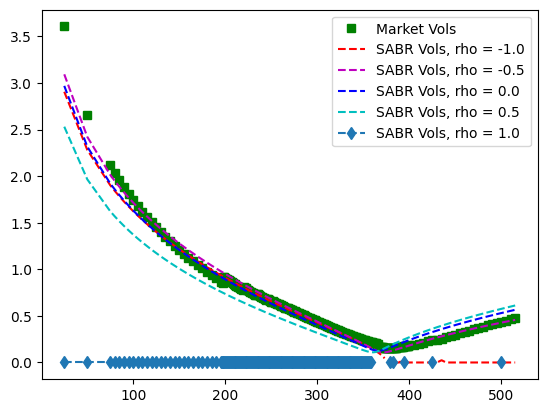

In [93]:
##### plt.figure(tight_layout=True)
plt.plot(strikes, SPY_df_17['impliedvol'], 'gs', label='Market Vols')
#plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strikes, all_sabrvols[0], 'r--', label='SABR Vols, rho = -1.0')
plt.plot(strikes, all_sabrvols[1], 'm--', label='SABR Vols, rho = -0.5')
plt.plot(strikes, all_sabrvols[2], 'b--', label='SABR Vols, rho = 0.0')
plt.plot(strikes, all_sabrvols[3], 'c--', label='SABR Vols, rho = 0.5')
plt.plot(strikes, all_sabrvols[4], 'd--', label='SABR Vols, rho = 1.0')


#plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

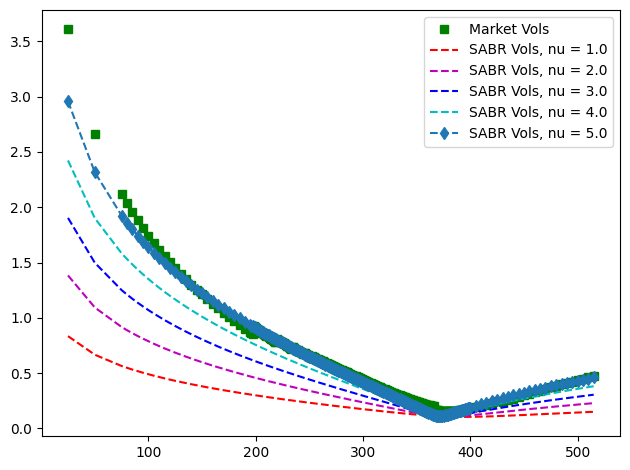

In [95]:
plt.figure(tight_layout=True)
plt.plot(strikes, SPY_df_17['impliedvol'], 'gs', label='Market Vols')
#plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strikes, all_sabrvols_nu[0], 'r--', label='SABR Vols, nu = 1.0')
plt.plot(strikes, all_sabrvols_nu[1], 'm--', label='SABR Vols, nu = 2.0')
plt.plot(strikes, all_sabrvols_nu[2], 'b--', label='SABR Vols, nu = 3.0')
plt.plot(strikes, all_sabrvols_nu[3], 'c--', label='SABR Vols, nu = 4.0')
plt.plot(strikes, all_sabrvols_nu[4], 'd--', label='SABR Vols, nu = 5.0')


#plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

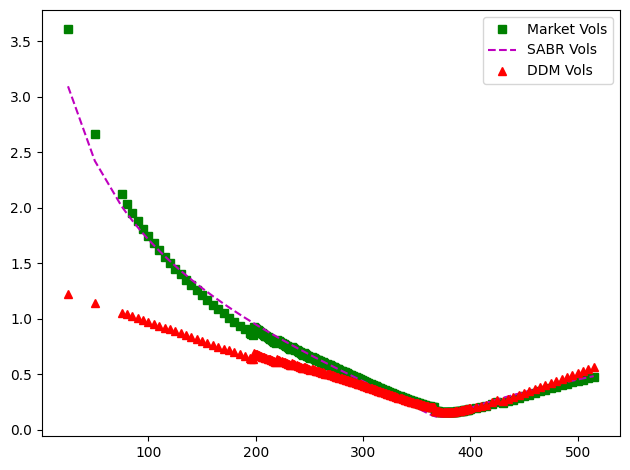

In [16]:
plt.figure(tight_layout=True)
plt.plot(strikes, SPY_df_17['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

## DDM Calibration, SPY, 45 days

In [17]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        else:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPY_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[1]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.21 / 100.0  # Modify as needed
F = 366.02*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put

# # Plot the implied volatility smile curve for out-of-the-money options
# plt.plot(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.1959716399049257, beta: 2.051636220375425e-07


## SABR Calibration, SPY, 45 days

In [18]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

SPY_df_45 = pd.read_csv('SPY_options.csv')
SPY_df_45['mid'] = 0.5*(SPY_df_45['best_bid'] + SPY_df_45['best_offer'])
SPY_df_45['strike'] = SPY_df_45['strike_price']*0.001
SPY_df_45['payoff'] = SPY_df_45['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(SPY_df_45['exdate'].unique())[1]
SPY_df_45 = SPY_df_45[SPY_df_45['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 366.02
r = 0.21/100.0 #modify?
F = S*np.exp(r*T)

SPY_df_45['vols'] = SPY_df_45.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
SPY_df_45.dropna(inplace=True)
call_df = SPY_df_45[SPY_df_45['payoff'] == 'call']
put_df = SPY_df_45[SPY_df_45['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
SPY_df_45 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              SPY_df_45['strike'],
                                              SPY_df_45['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

# plt.figure(tight_layout=True)
# plt.plot(strikes, SPY_df_45['impliedvol'], 'gs', label='Market Vols')
# plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
# plt.legend()
# plt.show()

Calibrated SABR model parameters: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


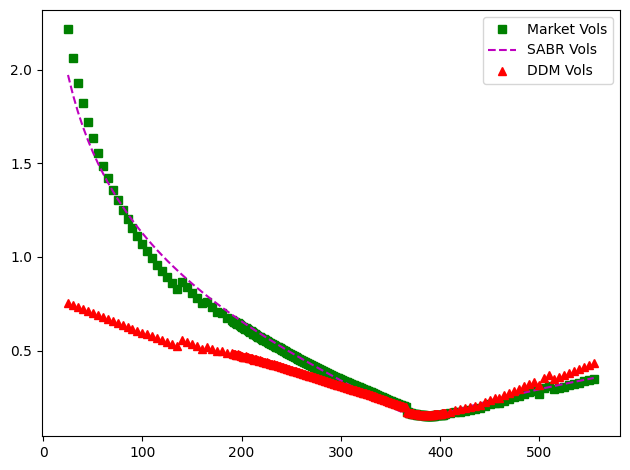

In [19]:
plt.figure(tight_layout=True)
plt.plot(strikes, SPY_df_45['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()

## DDM Calibration, SPY, 80 days

In [20]:
# Updated DDM Call Option Price
def DDMCall(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((F / beta) * norm.cdf(d1) - (K + ((1 - beta) / beta) * F) * norm.cdf(d2))

# Updated DDM Put Option Price
def DDMPut(F, K, r, sigma, T, beta):
    d1 = (np.log((F / beta) / (K + ((1 - beta) / beta) * F)) + ((beta * sigma) ** 2 / 2) * T) / (beta * sigma * np.sqrt(T))
    d2 = d1 - beta * sigma * np.sqrt(T)
    return np.exp(-r * T) * ((K + ((1 - beta) / beta) * F) * norm.cdf(-d2) - (F / beta) * norm.cdf(-d1))

# Objective function for calibration of sigma and beta
def calibration_objective(params, F, r, T, call_prices, put_prices, strikes):
    sigma, beta = params
    error = 0
    for i in range(len(strikes)):
        K = strikes[i]
        if i < len(call_prices):
            model_price = DDMCall(F, K, r, sigma, T, beta)
        else:
            model_price = DDMPut(F, K, r, sigma, T, beta)
        if i < len(call_prices):
            error += (model_price - call_prices[i]) ** 2
        else:
            error += (model_price - put_prices[i - len(call_prices)]) ** 2
    return error

# Calculate implied volatility from option price for both call and put options
def impliedVolatility(F, K, r, price, T, beta):
    try:
        if K > F:
            impliedVol = brentq(lambda x: price - DDMCall(F, K, r, x, T, beta), 1e-6, 10)
        else:
            impliedVol = brentq(lambda x: price - DDMPut(F, K, r, x, T, beta), 1e-6, 10)
    except Exception:
        impliedVol = np.nan
    return impliedVol

# Load market data (replace 'SPX_options.csv' with your actual CSV file)
market_df = pd.read_csv('SPY_options.csv')
market_df['mid'] = 0.5 * (market_df['best_bid'] + market_df['best_offer'])
market_df['strike'] = market_df['strike_price'] * 0.001
market_df['payoff'] = market_df['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(market_df['exdate'].unique())[2]
market_df = market_df[market_df['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry / 365
r = 0.22 / 100.0  # Modify as needed
F = 366.02*np.exp(r*T)  # Forward price

strikes = market_df['strike'].values
call_df = market_df[market_df['payoff'] == 'call']
put_df = market_df[market_df['payoff'] == 'put']
call_prices = call_df['mid'].values
put_prices = put_df['mid'].values

# Initial guess for the calibration (sigma, beta)
initial_guess = [0.1, 0.2]  # Initial guess for both sigma and beta

# Define bounds for optimization (assuming beta should be between 0 and 1)
beta_bounds = Bounds(0.0, 1.0)

# Modify the calibration function to include bounds
#result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)


# Calibrate sigma and beta for all DDM Call and DDM Put options combined
result = minimize(calibration_objective, initial_guess, args=(F, r, T, call_prices, put_prices, strikes), method='SLSQP', bounds=beta_bounds)

# Extract calibrated parameters
calibrated_sigma, calibrated_beta = result.x

print(f'Calibrated DDM - sigma: {calibrated_sigma}, beta: {calibrated_beta}')

# Filter out-of-the-money options
out_of_the_money_calls = call_df[call_df['strike'] > F]
out_of_the_money_puts = put_df[put_df['strike'] < F]

# Calculate implied volatilities for out-of-the-money calls and puts
implied_vols_call = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_calls['strike'], out_of_the_money_calls['mid'])]
implied_vols_put = [impliedVolatility(F, K, r, price, T, calibrated_beta) for K, price in zip(out_of_the_money_puts['strike'], out_of_the_money_puts['mid'])]

# Combine strike prices and implied volatilities for calls and puts
strike_prices = list(out_of_the_money_calls['strike']) + list(out_of_the_money_puts['strike'])
implied_vols_DDM = implied_vols_call + implied_vols_put

# # Plot the implied volatility smile curve for out-of-the-money options
# plt.plot(strike_prices, implied_vols_DDM, label='Implied Volatility (OTM)', linewidth=2.0)

# plt.xlabel('Strike Prices')
# plt.ylabel('Implied Volatility')
# plt.title('Implied Volatility Smile Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Calibrated DDM - sigma: 0.20184228323081113, beta: 8.849882632278039e-13


## SABR Calibration, SPY, 80 days

In [21]:
beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol

SPY_df_80 = pd.read_csv('SPY_options.csv')
SPY_df_80['mid'] = 0.5*(SPY_df_80['best_bid'] + SPY_df_80['best_offer'])
SPY_df_80['strike'] = SPY_df_80['strike_price']*0.001
SPY_df_80['payoff'] = SPY_df_80['cp_flag'].map(lambda x: 'call' if x == 'C' else 'put')
exdate = sorted(SPY_df_80['exdate'].unique())[2]
SPY_df_80 = SPY_df_80[SPY_df_80['exdate'] == exdate]
days_to_expiry = (pd.Timestamp(str(exdate)) - pd.Timestamp('2020-12-01')).days
T = days_to_expiry/365
S = 366.02
r = 0.22/100.0 #modify?
F = S*np.exp(r*T)

SPY_df_80['vols'] = SPY_df_80.apply(lambda x: impliedVolatility(S,
                                                  x['strike'],
                                                  r,
                                                  x['mid'],
                                                  T,
                                                  x['payoff']),
                      axis=1)
SPY_df_80.dropna(inplace=True)
call_df = SPY_df_80[SPY_df_80['payoff'] == 'call']
put_df = SPY_df_80[SPY_df_80['payoff'] == 'put']
strikes = put_df['strike'].values
impliedvols = []
for K in strikes:    
    if K > S:
        impliedvols.append(call_df[call_df['strike'] == K]['vols'].values[0])
    else:
        impliedvols.append(put_df[put_df['strike'] == K]['vols'].values[0])

# populate "df" with the dataframe containing strikes and market implied volatilities
SPY_df_80 = pd.DataFrame({'strike': strikes, 'impliedvol': impliedvols})

initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              SPY_df_80['strike'],
                                              SPY_df_80['impliedvol'],
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

sabrvols = []
for K in strikes:
    sabrvols.append(SABR(F, K, T, alpha, beta, rho, nu))

# plt.figure(tight_layout=True)
# plt.plot(strikes, SPY_df_80['impliedvol'], 'gs', label='Market Vols')
# plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
# plt.legend()
# plt.show()

Calibrated SABR model parameters: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


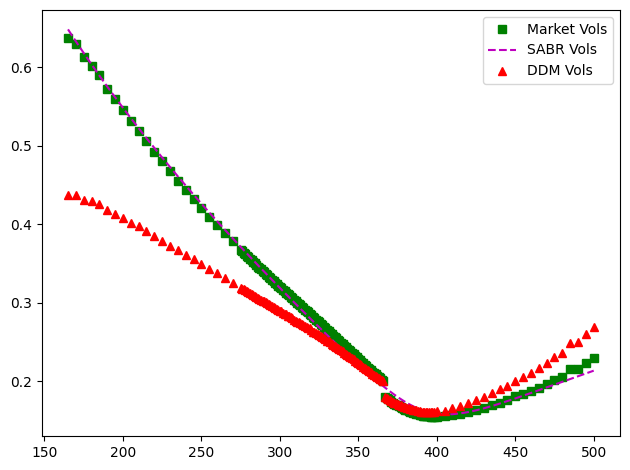

In [22]:
plt.figure(tight_layout=True)
plt.plot(strikes, SPY_df_80['impliedvol'], 'gs', label='Market Vols')
plt.plot(strikes, sabrvols, 'm--', label='SABR Vols')
plt.plot(strike_prices, implied_vols_DDM,'r^', label='DDM Vols')
plt.legend()
plt.show()